In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from category_encoders import LeaveOneOutEncoder

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

import warnings

warnings.filterwarnings('ignore')

C:\Users\user\anaconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv('./train.csv').drop('id',axis=1)
train.Class.value_counts()

0    218660
1       469
Name: Class, dtype: int64

In [3]:
test = pd.read_csv('./test.csv')

In [4]:
train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,120580.0,1.891079,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,-1.102824,...,-0.181369,-0.456538,-0.069571,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.65,0
219125,120580.0,0.139724,0.948649,-2.913655,-2.184829,1.883716,-1.056824,1.725624,0.018089,-0.823494,...,0.491469,1.478823,-0.085398,-0.091409,-1.053488,0.467570,0.358918,0.294735,24.00,0
219126,120580.0,2.058343,-0.038993,-1.928553,0.330117,0.270127,-0.735664,-0.173878,0.144823,0.849289,...,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,1.79,0
219127,120580.0,2.079227,-2.162389,-1.785833,-2.804889,0.552845,4.038013,-2.155900,1.023785,-0.865242,...,0.109909,0.590401,0.286621,0.675660,-0.510736,-0.090044,0.056749,-0.017126,88.00,0


In [5]:
origin = pd.read_csv('./creditcard.csv')
origin

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
train = pd.concat([train,origin],axis=0).drop_duplicates()

In [7]:
train.Class.value_counts()

0    501884
1       942
Name: Class, dtype: int64

In [8]:
train = train.reset_index(drop=True)

In [9]:
# np.array(train.Amount).reshape(-1,1)

In [10]:
from sklearn.preprocessing import MinMaxScaler
MM = MinMaxScaler()
MM.fit(np.array(train.Amount).reshape(-1,1))
tp = MM.transform(np.array(train.Amount).reshape(-1,1))
train['Amount'] = tp

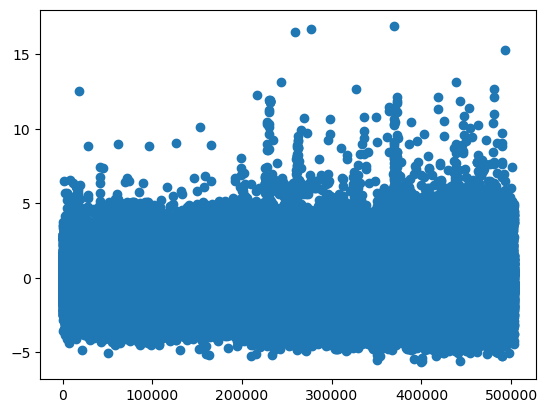

In [11]:
plt.scatter(range(len(train)),train.V4)

In [12]:
train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [13]:
# drop V15,V23,V20,V5,V28,time

In [14]:
target = 'Class'
features = ['V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19',
       'V21', 'V22', 'V24', 'V25', 'V26', 'V27', 'Amount']

features = [ 'V1', 'V2', 'V3', 'V4', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19',
       'V21', 'V24', 'V25', 'V26']

In [15]:
kf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
models = []
val_scores = []

include_orig = True

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = CatBoostClassifier(n_estimators=15000,
                               max_depth=4,
                               early_stopping_rounds = 200,
                               learning_rate=0.019,
                               one_hot_max_size = 3,
                               bootstrap_type = "MVS",
                               l2_leaf_reg = 2,
                               random_state = 1)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 2000)
    
    models.append(model)
    pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, pred)
    val_scores.append(score)
    
    print(f'AUC on fold {i}: {score:.4f}')
    
print(f'mean AUC across all folds: {np.mean(val_scores):.4f}')

0it [00:00, ?it/s]

0:	learn: 0.6309537	test: 0.6310753	best: 0.6310753 (0)	total: 187ms	remaining: 46m 38s


1it [00:17, 17.98s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.008227490678
bestIteration = 950

Shrink model to first 951 iterations.
AUC on fold 0: 0.8902
0:	learn: 0.6311669	test: 0.6312980	best: 0.6312980 (0)	total: 40.7ms	remaining: 10m 10s


2it [00:31, 15.31s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.007899131362
bestIteration = 654

Shrink model to first 655 iterations.
AUC on fold 1: 0.8754
0:	learn: 0.6311743	test: 0.6312795	best: 0.6312795 (0)	total: 38.6ms	remaining: 9m 39s


3it [00:53, 18.19s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.00735372337
bestIteration = 1188

Shrink model to first 1189 iterations.
AUC on fold 2: 0.8895
0:	learn: 0.6310759	test: 0.6311417	best: 0.6311417 (0)	total: 35.8ms	remaining: 8m 56s


4it [01:07, 16.60s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.007755841414
bestIteration = 677

Shrink model to first 678 iterations.
AUC on fold 3: 0.9080
0:	learn: 0.6309409	test: 0.6310738	best: 0.6310738 (0)	total: 62.4ms	remaining: 15m 35s


5it [01:34, 20.46s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.008340306961
bestIteration = 1551

Shrink model to first 1552 iterations.
AUC on fold 4: 0.8813
0:	learn: 0.6310814	test: 0.6311267	best: 0.6311267 (0)	total: 53ms	remaining: 13m 15s
2000:	learn: 0.0065556	test: 0.0076472	best: 0.0076472 (2000)	total: 30.3s	remaining: 3m 16s


6it [02:09, 25.26s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.007645301661
bestIteration = 2043

Shrink model to first 2044 iterations.
AUC on fold 5: 0.9094
0:	learn: 0.6311328	test: 0.6312100	best: 0.6312100 (0)	total: 72.8ms	remaining: 18m 11s


7it [02:32, 24.79s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.007857650558
bestIteration = 1335

Shrink model to first 1336 iterations.
AUC on fold 6: 0.8847
0:	learn: 0.6310526	test: 0.6311666	best: 0.6311666 (0)	total: 37.7ms	remaining: 9m 25s


8it [02:48, 21.91s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.009094998054
bestIteration = 810

Shrink model to first 811 iterations.
AUC on fold 7: 0.8573
0:	learn: 0.6311791	test: 0.6312888	best: 0.6312888 (0)	total: 28.6ms	remaining: 7m 8s


9it [03:20, 24.89s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.007441084215
bestIteration = 1767

Shrink model to first 1768 iterations.
AUC on fold 8: 0.8796
0:	learn: 0.6310694	test: 0.6311537	best: 0.6311537 (0)	total: 19.3ms	remaining: 4m 48s
2000:	learn: 0.0065779	test: 0.0077270	best: 0.0077251 (1939)	total: 30.5s	remaining: 3m 17s


10it [04:00, 24.09s/it]

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.00769420212
bestIteration = 2433

Shrink model to first 2434 iterations.
AUC on fold 9: 0.9027
mean AUC across all folds: 0.8878


In [16]:
val_scores

[0.8901889156859412,
 0.8753687656403476,
 0.8895381839624941,
 0.9079922573523146,
 0.8813461385191679,
 0.9094451179355099,
 0.8846948240572893,
 0.8573143703080672,
 0.8796440278171098,
 0.9027007388389867]

In [17]:
sum(val_scores)/10

0.887823334011723

In [18]:
# kf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
# val_scores = []

# include_orig = True

# for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
#     X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
#     y_train, y_val = train[target][train_index], train[target][val_index]
    
# #     if include_orig:
# #         X_train = X_train.append(original[features], ignore_index = True)
# #         y_train = y_train.append(original[target], ignore_index = True)
    
#     model = XGBClassifier(n_estimators=2000,
#                           max_depth=3,
#                           early_stopping_rounds = 200,
#                           reg_lambda = 2.5,
#                           reg_alpha = 0.01015,
#                           learning_rate=0.146,
#                           eval_metric = "auc",
#                           gamma = 0.14,
#                           random_state = 1)
    
#     model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 1000)
    
#     models.append(model)
#     pred = model.predict_proba(X_val)[:,1]
#     score = roc_auc_score(y_val, pred)
#     val_scores.append(score)
    
#     print(f'AUC on fold {i}: {score:.4f}')
    
# print(f'mean AUC across all folds: {np.mean(val_scores):.4f}')

In [19]:
# val_scores

In [34]:
from lightgbm import log_evaluation, early_stopping
kf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
val_scores = []

include_orig = True
params={'objective': 'binary',
             'metric': 'auc',
             'lambda_l1': 1.0050418664783436e-08, 
             'lambda_l2': 9.938606206413121,
             'scale_pos_weight': 1, #param could be ignored
             'num_leaves': 44,
             'feature_fraction': 0.8247273276668773,
             'bagging_fraction': 0.5842711778104962,
             'bagging_freq': 6,
             'min_data_in_leaf': 134,
             'min_child_samples': 70,
             'max_depth': 8,
             'num_iterations': 400,
             'learning_rate':0.05}

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train, train[target]))):
    
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
#     if include_orig:
#         X_train = X_train.append(original[features], ignore_index = True)
#         y_train = y_train.append(original[target], ignore_index = True)
    
    model = LGBMClassifier(**params)

    callbacks = [log_evaluation(period=200), early_stopping(stopping_rounds=200)]
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], callbacks = callbacks)
    
    models.append(model)
    pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, pred)
    val_scores.append(score)
    
    print(f'AUC on fold {i}: {score:.4f}')
    
print(f'mean AUC across all folds: {np.mean(val_scores):.4f}')

0it [00:00, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.887323


1it [00:03,  3.02s/it]

Early stopping, best iteration is:
[112]	valid_0's auc: 0.897633
AUC on fold 0: 0.8976
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.902385


2it [00:05,  2.99s/it]

Early stopping, best iteration is:
[99]	valid_0's auc: 0.910637
AUC on fold 1: 0.9106
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.894695


3it [00:09,  3.11s/it]

Early stopping, best iteration is:
[132]	valid_0's auc: 0.898622
AUC on fold 2: 0.8986
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.908194


4it [00:13,  3.41s/it]

[400]	valid_0's auc: 0.897414
Did not meet early stopping. Best iteration is:
[244]	valid_0's auc: 0.910487
AUC on fold 3: 0.9105
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[2

5it [00:16,  3.26s/it]

Early stopping, best iteration is:
[109]	valid_0's auc: 0.878536
AUC on fold 4: 0.8785
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.91129


6it [00:19,  3.44s/it]

[400]	valid_0's auc: 0.907178
Did not meet early stopping. Best iteration is:
[293]	valid_0's auc: 0.91776
AUC on fold 5: 0.9178
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[20

7it [00:23,  3.59s/it]

[400]	valid_0's auc: 0.881022
Did not meet early stopping. Best iteration is:
[239]	valid_0's auc: 0.887074
AUC on fold 6: 0.8871
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[2

8it [00:26,  3.36s/it]

Early stopping, best iteration is:
[94]	valid_0's auc: 0.882692
AUC on fold 7: 0.8827
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.892923


9it [00:30,  3.54s/it]

[400]	valid_0's auc: 0.894893
Did not meet early stopping. Best iteration is:
[303]	valid_0's auc: 0.897437
AUC on fold 8: 0.8974
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] lambda_l1 is set=1.0050418664783436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0050418664783436e-08
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] lambda_l2 is set=9.938606206413121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.938606206413121
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 200 rounds
[2

10it [00:33,  3.31s/it]

Early stopping, best iteration is:
[51]	valid_0's auc: 0.914167
AUC on fold 9: 0.9142
mean AUC across all folds: 0.8995


In [35]:
val_scores

[0.8976326931009295,
 0.9106366233509674,
 0.8986220384817729,
 0.9104868702686822,
 0.8785364922627763,
 0.9177599593947809,
 0.8870737516300412,
 0.8826917174402968,
 0.8974369137998572,
 0.9141665635084423]

In [36]:
sum(val_scores)/10

0.8995043623238546

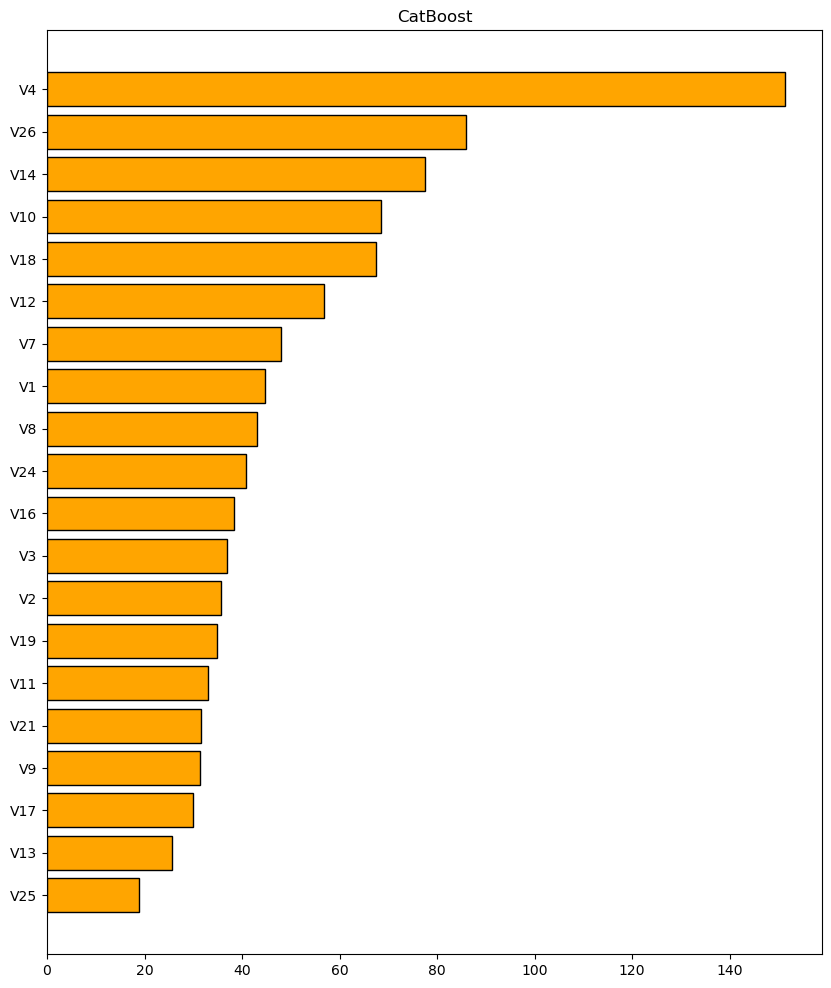

In [23]:
plt.figure(figsize = (10, 12))
cat_imp = np.zeros(len(features))
for model in models[:10]:
    cat_imp += model.feature_importances_
    
plt.barh([features[i] for i in np.argsort(cat_imp)], sorted(cat_imp), 
         color = "orange", edgecolor = "#000000")

plt.title("CatBoost")
plt.show()

In [24]:
# plt.figure(figsize = (10, 12))
# xgb_imp = np.zeros(len(features))
# for model in models[10:20]:
#     xgb_imp += model.feature_importances_
    
# plt.barh([features[i] for i in np.argsort(xgb_imp)], sorted(xgb_imp), 
#          color = "purple", edgecolor = "#000000")

# plt.title("XGBoost")
# plt.show()

In [25]:
# plt.figure(figsize = (10, 12))
# lgbm_imp = np.zeros(len(features))
# for model in models[10:]:
#     lgbm_imp += model.feature_importances_
    
# plt.barh([features[i] for i in np.argsort(lgbm_imp)], sorted(lgbm_imp), 
#          color = "blue", edgecolor = "#000000")

# plt.title("LGBM")
# plt.show()

In [26]:
cat_preds = []
xgb_preds = []
lgbm_preds = []

for model in models[:10]:
    preds = model.predict_proba(test[features])[:,1]
    cat_preds.append(preds)
    
# for model in models[10:20]:
#     preds = model.predict_proba(test[features])[:,1]
#     xgb_preds.append(preds)
    
# for model in models[10:]:
#     preds = model.predict_proba(test[features])[:,1]
#     lgbm_preds.append(preds)

In [27]:
cat_preds = np.stack(cat_preds).mean(0)
cat_preds # cv 10개 모델의 평균

array([0.00088207, 0.00087874, 0.00044868, ..., 0.0007158 , 0.00026907,
       0.00025101])

In [28]:
# cat_preds = np.stack(cat_preds).mean(0)
# xgb_preds = np.stack(xgb_preds).mean(0)
# lgbm_preds = np.stack(lgbm_preds).mean(0)

In [29]:
cat_df = pd.DataFrame(data = {'id': test.id, 'Class': cat_preds})
# xgb_df = pd.DataFrame(data = {'id': test.id, 'Class': xgb_preds})
# lgbm_df = pd.DataFrame(data = {'id': test.id, 'Class': lgbm_preds})

# print("Cat Correlation with XGB:")
# display(cat_df.Class.corr(xgb_df.Class))
# print("Cat Correlation with LGBM:")
# display(cat_df.Class.corr(lgbm_df.Class))
# print("XGB Correlation with LGBM:")
# display(xgb_df.Class.corr(lgbm_df.Class))

In [30]:
# blended_preds = cat_preds * 0.5 lgbm_preds * 0.3
# blended_preds

In [31]:
# submission = pd.DataFrame(data = {'id': test.id, 'Class': blended_preds})
submission = cat_df

<AxesSubplot: >

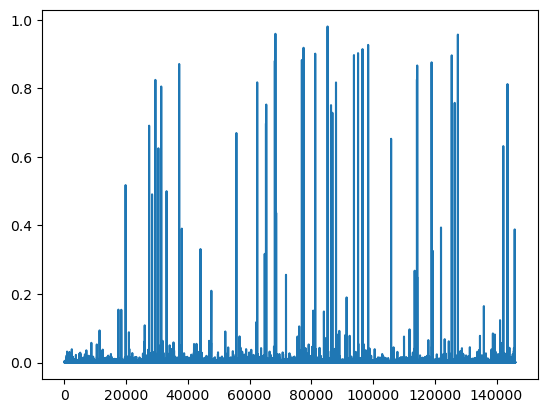

In [32]:
submission.Class.plot()

In [33]:
submission.to_csv('submission.csv', index=False)